In [18]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '..')

from sim.LoadBalancer import LoadBalancer
from sim.Source import ArrivalSchedule, Source
from sim.Environment import Environment
from sim.GELoadBalancer import GreedyEpsilonLoadBalancer
from experiments.nonlinearRegModel import NonLinearReg

import numpy as np
import random
import matplotlib.pyplot as plt
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test for fixed rate

In [2]:
from BinarySearch import binaryServerSearch

opt = binaryServerSearch(10,[0,40])
print(opt)

18


In [3]:
def sigmoid(x):
      return 1 / (1 + np.exp(-x))

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
stopTime = 4*7*24*60*60
env = Environment(stopTime=stopTime)

#model = LinearRegression()
#model = DecisionTreeRegressor()
#model  = MLPRegressor(hidden_layer_sizes=[10], activation='tanh')
model = NonLinearReg()
#model  = RandomForestRegressor(n_estimators=10)
eta = lambda t: sigmoid(2-0.01*t)
#eta = 0.4
#sigmoid(2/(0.1*t+2)-0.5)
periodLength = 0.5*60*60 #half an hour per period -> schedule repeated two times in 12 hours
loadBalancer = GreedyEpsilonLoadBalancer(nServers=10, environment=env, model = model, eta=eta, nServerRange=[10,30], usePartialFit=False, periodLength=periodLength)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 10
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

schedule = np.array([arrivalsPerSecond]) #12 periods
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

17976 1085 10 5626.0
21
17969 3 21 14789.0


TypeError: vstack() got an unexpected keyword argument 'axis'

In [14]:
pred = np.array(env.log['numberOfServers'][::2])
ged = np.array(env.log['greedyEpsilonActionType'])
mse = (pred[ged==1] - 16)**2
print(np.mean(mse))
reward  = np.array(env.log['reward'])[ged==1]
print(np.sum(reward))

3.988536155202822
17374557.0


In [23]:
import pandas as pd
pd.DataFrame(list(loadBalancer.X)).head(10)

,0,1,2,3,4,5,6,7
0,41.078801,18061.0,18061.0,3.999437,17998.0,5.496484,1058.0,10.0
1,40.731452,17998.0,17998.0,3.987708,18013.0,5.490252,1063.0,25.0
2,1.895238,17946.0,17946.0,0.023889,17978.0,1.529167,4.0,13.0
3,39.610290,17917.0,17917.0,3.911379,17876.0,5.400392,521.0,23.0
4,2.302510,18000.0,18000.0,0.058628,18040.0,1.559644,4.0,21.0
5,1.870924,17974.0,17974.0,0.082791,17976.0,1.583690,0.0,30.0
6,0.718750,17986.0,17986.0,0.000595,17981.0,1.503360,0.0,27.0
7,0.756250,17889.0,17889.0,0.002467,17897.0,1.497113,0.0,21.0
8,1.649328,18024.0,18024.0,0.075194,18014.0,1.570804,0.0,15.0
9,28.722877,18128.0,18128.0,2.764029,18100.0,4.258687,141.0,25.0


In [24]:
print(loadBalancer.X.shape, loadBalancer.y.shape)


(480, 8) (479, 1)


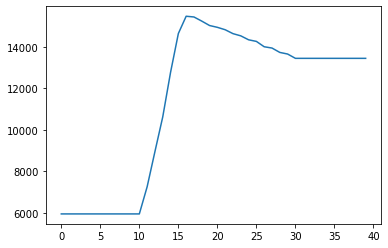

In [37]:
X = loadBalancer.X[-100,:]
X
pred = []
for n  in range(0,40):
    X_ = np.append(X[:-1], n)
    rewardHat = loadBalancer.model.predict(X_[None,:])[0]
    pred.append(rewardHat)

plt.plot(range(0,40), pred)

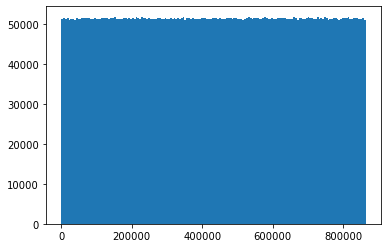

In [14]:
plt.hist(env.logTime['arrivalEvent'], bins=7*24);

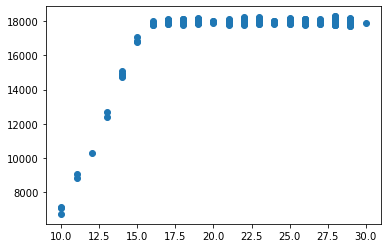

In [15]:
plt.scatter(env.log['numberOfServers'][::2], env.log['reward'])

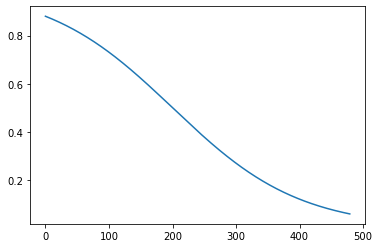

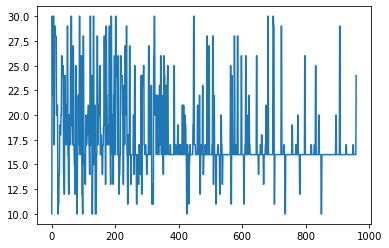

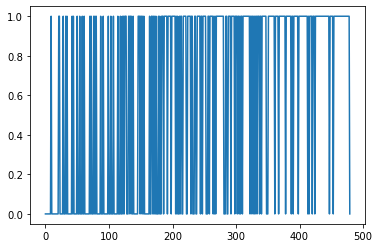

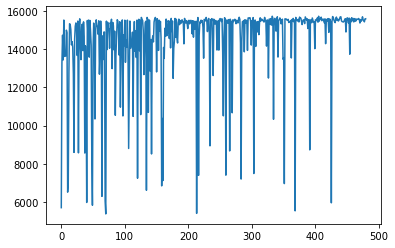

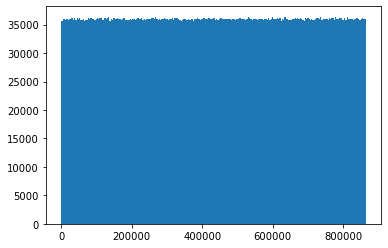

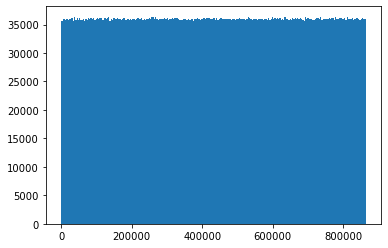

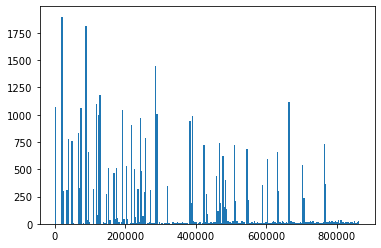

In [5]:
plt.plot(env.log['eta'])
plt.figure()
plt.plot(env.log['numberOfServers'])
plt.figure()
plt.plot(env.log['greedyEpsilonActionType'])
plt.figure()
plt.plot(env.log['reward'])
plt.figure()
plt.hist(env.logTime['arrivalEvent'], bins=int(stopTime/60/60));
plt.figure()
plt.hist(env.logTime['requestProcessed'], bins=int(stopTime/60/60));
plt.figure()
plt.hist(env.logTime['requestCancelled'], bins=int(stopTime/60/60));

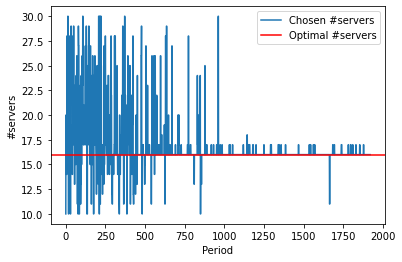

In [12]:
plt.plot(env.log['numberOfServers'], label = 'Chosen #servers')
plt.axhline(y=16, label='Optimal #servers', color='red')
plt.xlabel('Period')
plt.ylabel('#servers')
plt.legend()

In [10]:
pred = np.array(env.log['numberOfServers'][::2])
ged = np.array(env.log['greedyEpsilonActionType'])
mse = (pred[ged==1] - 16)**2
print(np.mean(mse))
reward  = np.array(env.log['reward'])[ged==1]
print(np.sum(reward))

3.7877442273534636
17217137.0


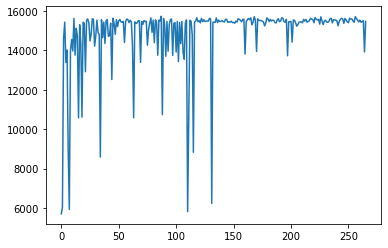

In [41]:
plt.plot(np.array(env.log['reward'])[np.array(env.log['greedyEpsilonActionType'])==1.0])

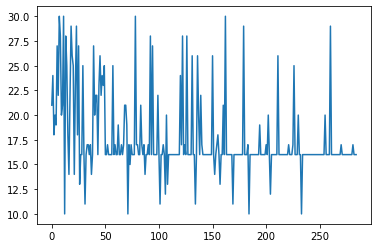

In [6]:
plt.plot(np.array(env.log['numberOfServers'][::2])[np.array(env.log['greedyEpsilonActionType'])==1.0])

Text(0, 0.5, 'y')

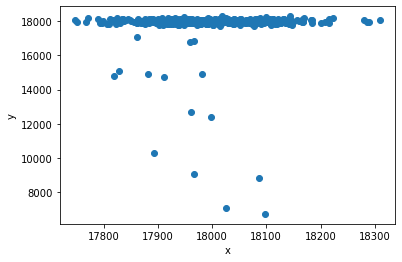

In [19]:
plt.scatter(loadBalancer.X[:-1,2],loadBalancer.y)
plt.xlabel('x')
plt.ylabel('y')

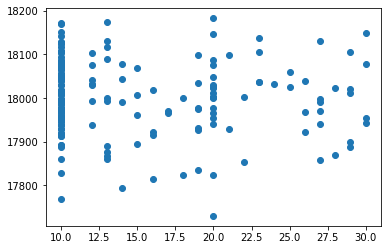

In [52]:
plt.scatter(env.log['numberOfServers'][0::2],env.log['reward'])

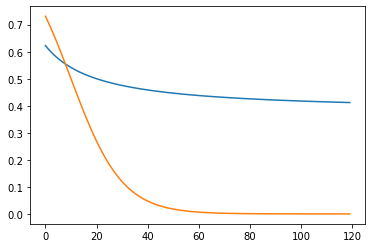

In [31]:

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

x = np.arange(0,120,1)
plt.plot(x, sigmoid(2/(0.1*x+2)-0.5))
plt.plot(x, sigmoid(1-0.1*x))

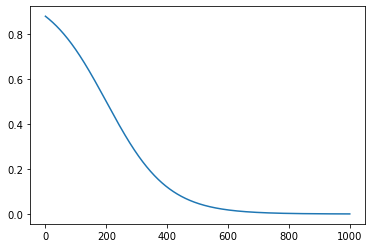

In [34]:
x = np.arange(0,1000,1)
plt.plot(x, sigmoid(2-0.01*x))

In [43]:
loadBalancer.X[-100,:-1]

array([1.65307145e+01, 1.80810000e+04, 1.80810000e+04, 1.51028865e+00,
       1.80750000e+04, 3.01130382e+00, 1.70000000e+01])

In [52]:
A = np.array([0,0.1,0,0,0,0,0.1])
print(loadBalancer.X[-100,:-1]@A/60/60)
sigmoid(loadBalancer.X[-100,:-1]@A/60/60) * 20

0.5027222222222223


12.461976998873004

In [53]:
loadBalancer.X[-100,:-1]

array([1.65307145e+01, 1.80810000e+04, 1.80810000e+04, 1.51028865e+00,
       1.80750000e+04, 3.01130382e+00, 1.70000000e+01])

In [54]:
1.80810000e+04

18081.0